In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 

from sklearn.linear_model import LinearRegression, Ridge, Lasso , SGDRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn import datasets

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Linear Regression

### The Normal Equation

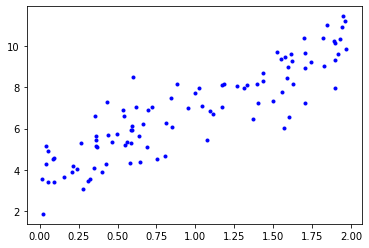

In [2]:
X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)
plt.plot(X,y,'b.')

In [3]:
## Add x0 = 1 to each instance 
X_b = np.c_[np.ones((100,1)), X]
theta_hat = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_hat ## Close enough to ø0 = 4, ø1 = 3.. 

array([[3.77442944],
       [3.17490602]])

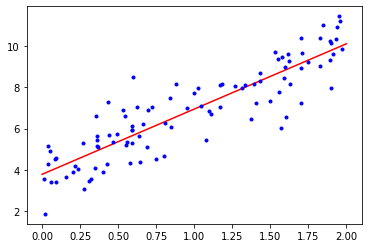

In [4]:
X_new_b = np.c_[np.ones((2,1)),np.array([[0],[2]])]
y_predict = X_new_b.dot(theta_hat) ## (2x2).(2,1) -> (2x1)
plt.plot(np.array([[0],[2]]), y_predict, 'r-')
plt.plot(X,y, 'b.')

In [5]:
## @source: http://www.ds100.org/fa17/assets/notebooks/22-lec/LeastSquares.html

In [6]:
## Similarily, performing Linear Regression in scikit 
lr = LinearRegression()
lr.fit(X,y) 
print('Linear Regression intercept: {}. Coef: {}'.format(lr.intercept_, lr.coef_))

## Note: LinearRegression class is based on scipy.linealg.lstsq() function 

Linear Regression intercept: [3.77442944]. Coef: [[3.17490602]]


### Batch Gradient Descent 

In [7]:
## Batch gradient descent: 
## Gradient vector contains all the partial derivatives of the cost function: 
eta = .1 # learning rate 
n_iterations = 1000 
m = 100 

theta_iters = []

theta = np.random.randn(2,1) # Random init 

for iterations in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta)-y) # Gradient vector 
    theta_iters.append(theta)
    theta = theta - eta * gradients

    
theta

array([[3.77442944],
       [3.17490602]])

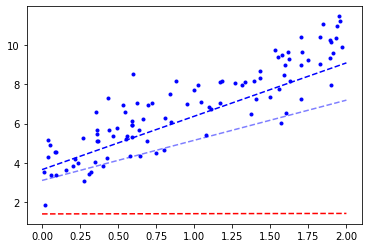

In [8]:
X_new_b = np.c_[np.ones((2,1)),np.array([[0],[2]])]
# y_predict = X_new_b.dot(theta_hat) ## (2x2).(2,1) -> (2x1)
# plt.plot(np.array([[0],[2]]), y_predict, 'r-')
plt.plot(X,y, 'b.')
y_predict_0 = X_new_b.dot(theta_iters[0])
y_predict_2 = X_new_b.dot(theta_iters[2])
y_predict_4 = X_new_b.dot(theta_iters[4])
plt.plot(np.array([[0],[2]]), y_predict_0, 'r--')
plt.plot(np.array([[0],[2]]), y_predict_2, 'b--', alpha = .5)
plt.plot(np.array([[0],[2]]), y_predict_4, 'b--') ## Fit found very quickly 

### Stochastic Gradient Descent 

In [9]:
## Stochastic gradient descent 
## + More randomness (get out of local minima)
## + Scales with increase in training size (only using one training instance at a time)
## - Never stabilizes due to random nature 

n_epochs = 50
t0, t1 = 5, 50 # Learning schedule hyperparameters
m = 100

def learning_schedule(t): 
    return t0 / (t + t1)

theta = np.random.randn(2,1)

for iterations in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m) # Select a number between 0 and 100 
        xi = X_b[random_index:random_index+1] # x[i:i+1] maintains index (2d array), x[i] does not, returns 1d np.array. See cell below 
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta)-yi)
        eta = learning_schedule(n_epochs * m + i) 
        theta = theta - eta * gradients
        
theta

array([[3.61725913],
       [3.30708307]])

In [10]:
print(X_b[1])
print(X_b[1:2])

[1.         1.11130146]
[[1.         1.11130146]]


## Polynomial Regression

In [11]:
## Generate a non linear and noisy dataset 
m = 200 
X = 6 * np.random.rand(m,1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)

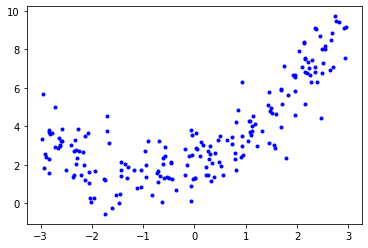

In [12]:
plt.plot(X, y, 'b.')

In [13]:
## Can still use a linear model to fit nonlinear data 
## Add powers of each feature to as new features and train linear model on extended feature set 
## --> Polynomial regression 
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

poly_reg = LinearRegression() 
poly_reg.fit(X_poly,y)
lin_reg = LinearRegression()
lin_reg.fit(X,y)

lin_reg.intercept_, lin_reg.coef_

(array([3.60264318]), array([[0.95172586]]))

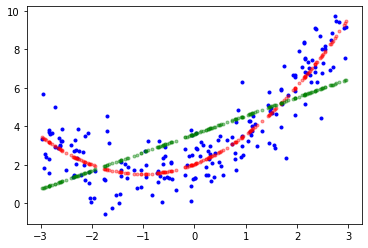

In [14]:


yhat_poly = poly_reg.predict(X_poly)
yhat_lin = lin_reg.predict(X)
plt.plot(X, y, 'b.')
plt.plot(X,yhat_poly, 'r.', alpha = .4)
plt.plot(X,yhat_lin, 'g.', alpha = .4)


## Learning Curves 

- Used to determine whether a model is under/over fitting the data 
- It's a plot of the model's performance on the training / validation sets 
- The model is trained several times on different sized subsets of the training set 

Text(30, 2, 'WRONG')

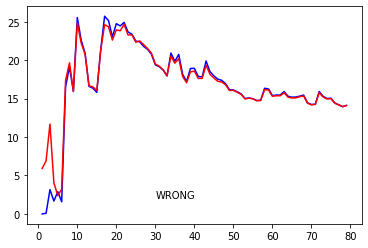

In [15]:
# def plot_learning_curves(model, X, y):
#     for i in range

lr = LinearRegression()
mse_train, mse_val = [], []


for train_set_size in range(1,80): 
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=train_set_size, ## WRONG 
                                                        shuffle=True,                   ##  VAL SET SHOULD
                                                        random_state=42)                ##  STAY THE SAME 
    lr.fit(X_train, y_train)
    yhat_train = lr.predict(y_train)
    yhat_val = lr.predict(y_test)
    
    mse_train.append(mean_squared_error(y_true=y_train, y_pred=yhat_train))
    mse_val.append(mean_squared_error(y_true=y_test, y_pred=yhat_val))
    
    
plt.plot(np.arange(1,80), mse_train, 'b-')
plt.plot(np.arange(1,80), mse_val, 'r-')
plt.text(30,2,"WRONG")
    

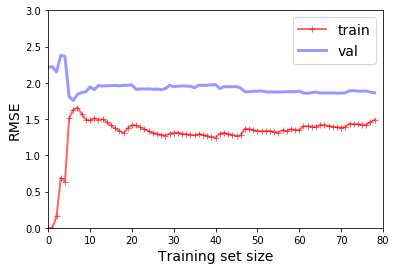

In [16]:
# def plot_learning_curves(model, X, y):
#     for i in range

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)



def plot_learning_curves(model,X,y):
    mse_train, mse_val = [], []
    X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state=10)         

    for train_set_size in range(1,len(X_train)): 
        X_train_subset, y_train_subset = X_train[:train_set_size], y_train[:train_set_size]
        model.fit(X_train_subset, y_train_subset) ## !!! on what you're predicting on.. 
        yhat_train = model.predict(X_train_subset)
        yhat_val = model.predict(X_val)

        mse_train.append(mean_squared_error(y_train_subset, yhat_train))
        mse_val.append(mean_squared_error(y_val,yhat_val))


    plt.plot(np.sqrt(mse_train), 'r-+', linewidth=2, label='train', alpha=.6)
    plt.plot(np.sqrt(mse_val), 'b-',linewidth=3, label='val', alpha=.4)    
    plt.axis([0, 80, 0, 3])                         # not shown in the book
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)  
    plt.show()
    
lr = LinearRegression()
plot_learning_curves(lr, X, y)
## Notes: Both curves reach a plateau, they are close and still pretty high 
## ----> Characteristic of model that underfits 

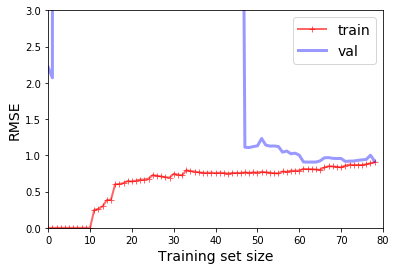

In [17]:
## How about doing the same with a 10th degree poly. model 
poly_pipe = Pipeline([
    ("poly_10", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression())
])
plot_learning_curves(poly_pipe,X,y) 

## Can automatically see: 
## - Error much lower than in previous model example 
## - There is a gap between training / val performance
## --> hallmark of overfitting model 

## Regularized Linear Models

- For linear models, regularization happens by constraining weights of the model. 
- A simple way is to regularize a polynomial model is to reduce the number of degrees 

### Ridge Regression

- In ridge regression, the term α * sum(øi^2) is added to the cost function. This forces the learning mdoel to fit the data but to also keep the weights as small as possible 
- NOTE: This regularization term should only be added to the cost function during training. When testing the model, use unregularized performance measures! 


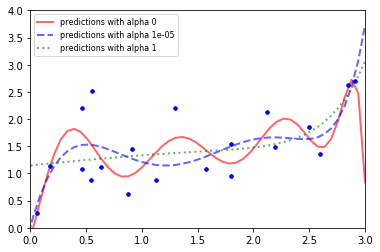

In [18]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def fit_and_plot( X, y):
    X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=.2,random_state=10)
    
    
    ## LR - no alpha
    X_new = np.linspace(-3,3,100).reshape(100,1)
        
    for alpha, color in zip([0, 10**-5, 1], ['r-', 'b--', 'g:']):
        lr_ridge_pipe = Pipeline([
            ('poly', PolynomialFeatures(degree=10, include_bias=False)),
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=alpha, solver='cholesky'))
        ])
        lr_ridge_pipe.fit(X,y)
        yhat_val = lr_ridge_pipe.predict(X_new)
        
    
        plt.plot(X_new, yhat_val,color,
                 linewidth=2,label='predictions with alpha {}'.format(alpha), alpha=.6)
        plt.plot(X,y, 'b.')
        plt.axis([0, 3, 0, 4])
        plt.legend(loc='upper left', fontsize=8)
    plt.show()
    
    
fit_and_plot(X,y)



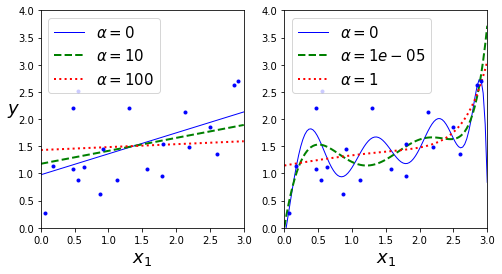

In [19]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])
#     ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

# save_fig("ridge_regression_plot")
plt.show()

### Lasso Regression

/Users/elieharik/Desktop/Dev/Books/Python/HandsOnML/env/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.802867703827423, tolerance: 0.0009294783355207351
  positive)


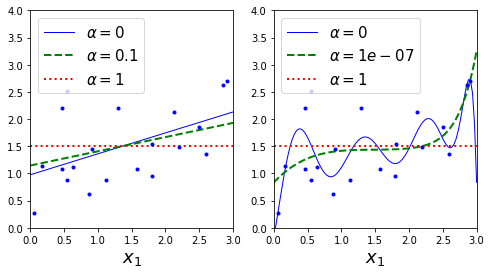

In [20]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0,0.1,1), random_state=42)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0,1e-7,1), random_state=42)
plt.show()

### Using Early Stopping to Regularize

In [21]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [22]:
print(y[:5])
print(y[:5].ravel()) # Ravel returns a flattened array 
print(y[:5].shape) # Shape (5,1)
print(y[:5].ravel().shape) # Shape (5,)


[[1.61761105]
 [8.06185944]
 [4.45250583]
 [0.77958493]
 [1.84625712]]
[1.61761105 8.06185944 4.45250583 0.77958493 1.84625712]
(5, 1)
(5,)


In [23]:
## Prepare the data - poly + scale 
poly_scaler = Pipeline([
    ('poly', PolynomialFeatures(degree=90, include_bias=False)),
    ('scaler', StandardScaler())
])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.fit_transform(X_val)

## SGDRegressor, max_iter=1, tol=-np.infinity .. 
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate='constant', eta0=.0005)

## Init starting variables 
best_model = None 
best_epoch = None 
minimum_val_error = float("inf")

## 1000 epoch
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    yhat_val = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, yhat_val) 
    if val_error < minimum_val_error:
        minimum_val_error
        best_epoch = epoch 
        best_model = clone(sgd_reg)

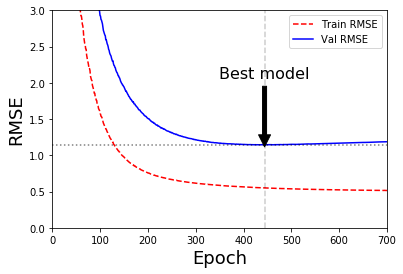

In [24]:
## Creating the graph 

## Re-init SGD  and vars 
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate='constant', eta0=.0005)

best_model = None 
best_epoch = None 
minimum_val_error = float("inf")

train_epoch_rmse = []
val_epoch_rmse = []

for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    
    yhat_train = sgd_reg.predict(X_train_poly_scaled)
    yhat_val = sgd_reg.predict(X_val_poly_scaled)
    val_error =  mean_squared_error(y_val, yhat_val)

    train_epoch_rmse.append((mean_squared_error(y_train, yhat_train)))
    val_epoch_rmse.append((val_error))

    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch 
        best_model = clone(sgd_reg)
        
best_epoch = np.argmin(val_epoch_rmse)
best_val_rmse = np.sqrt(val_epoch_rmse[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )
        
plt.plot(train_epoch_rmse, 'r--',label = 'Train RMSE')
plt.plot(val_epoch_rmse, 'b-', label = 'Val RMSE')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize= 18)
plt.ylabel('RMSE', fontsize= 18)
plt.axhline(y=minimum_val_error, linestyle=':',color='black', alpha = .5)
plt.axvline(x=best_epoch, linestyle = '--', color = 'black',alpha=.2)
plt.axis([0,700,0,3])
plt.show()



## Logistic Regression 

### Decision Boundaries 

In [25]:
iris = datasets.load_iris()
print("Iris Keys: {}".format(list(iris.keys())))
print("Iris Features: {}".format(iris['feature_names'])) ## Use Petal width 
print("Iris Target Names: {}".format(iris['target_names'])) 
X = iris.data[:,3:]
y = (iris.target == 2).astype(int)

Iris Keys: ['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']
Iris Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Iris Target Names: ['setosa' 'versicolor' 'virginica']


In [26]:
## Train simple logistic regression model 
logistic_reg = LogisticRegression() 
logistic_reg.fit(X, y)

/Users/elieharik/Desktop/Dev/Books/Python/HandsOnML/env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

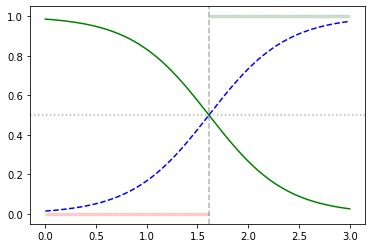

In [27]:
X_new = np.linspace(0,3,1000).reshape(-1,1) # Forces data to have one column. Rows determined by original shape \
y_proba = logistic_reg.predict_proba(X_new) 
yhat = logistic_reg.predict(X_new)
plt.plot(X_new, y_proba[:,0], 'g-', label='Iris Virginica')
plt.plot(X_new, y_proba[:,1], 'b--', label='Not Iris Virginica')
plt.plot(X_new[:np.argmin(yhat==0)], yhat[yhat==0], '.',color ='red', alpha =0.01)
plt.plot(X_new[np.argmax(yhat==1):], yhat[yhat==1], '.',color ='green', alpha =0.01)
plt.axvline(X_new[np.argmax(yhat==1)], linestyle = '--', color = 'black',  alpha = .3)
plt.axhline(.5, linestyle = ':', color='black', alpha=.3)

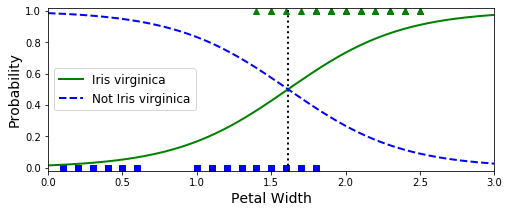

In [28]:
X_new = np.linspace(0,3,1000).reshape(-1,1) # Forces data to have one column. Rows determined by original shape \
y_proba = logistic_reg.predict_proba(X_new) 
decision_boundary = X_new[y_proba[:,1] >= .5][0] ## Getting first 'not virginica'

plt.figure(figsize=(8,3))
plt.plot(X[y==0], y[y==0],'bs')  # bs: Blue Square
plt.plot(X[y==1], y[y==1],'g^') # g^: Greeen triangle 
# plt.plot([decision_boundary, decision_boundary], [-1,2], 'k:', linewidth=2) ## Could use plt.axvline instead? here plotting line for points (dec_bound, -1) to (dec_bound,2)
plt.axvline(decision_boundary, linestyle=':', color = 'black', linewidth=2) # Looks like yes 
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.xlabel('Petal Width', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.legend(loc='center left', fontsize=12)
plt.axis([0,3,-0.02,1.02])
plt.show()

In [29]:
## How about when we train on two features: 
## .. Petal width and petal length 
X = iris.data[:,(2,3)]
y = (iris.target == 2).astype(int)
lr =  LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
lr.fit(X,y)



LogisticRegression(C=10000000000, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

[2.9, 7, 0.8, 2.7]

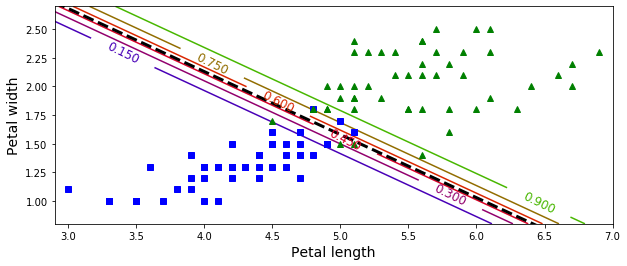

In [30]:
x0, x1 = np.meshgrid(
    np.linspace(2.9, 7,500).reshape(-1,1), 
    np.linspace(.8, 2.7, 200).reshape(-1,1)
)

## x0 goes from 2.9 to 7 w/ 500 evenly spaced numbers (200 rows, 500 columns) 
## .. each row goes from 2.9 to 7 with 500 even steps(hence the 500 cols) 
## X1 is each of the 200 .8 to 2.7 repeated 200 times (200 rows, 500 cols)
## .. on the other hand x1 is a number (from .8 to 2.7) repeated 500 times

## Again, def. of meshgrid.. 
## .. np.meshgrid returns coordinate matrices from coordinate vectors..  
## .. wth - basically think about it as getting all points (here in 2d) 
## ... with x0 being all points on x-axis (500 points from 2.9 to 7) 
## ... and x1 being all points on y axis (200 points from .8 to 2.7)

X_new = np.c_[x0.ravel(), x1.ravel()]
y_proba = lr.predict_proba(X_new)

plt.figure(figsize=(10,4))
plt.plot(X[y==0,0], X[y==0,1], 'bs')
plt.plot(X[y==1,0], X[y==1,1], 'g^')

## @Recode
zz = y_proba[:,1].reshape(x0.shape)
contour = plt.contour(x0,x1,zz,cmap=plt.cm.brg)

left_right = np.array([2.9, 7])
boundary = -(lr.coef_[0][0] * left_right + lr.intercept_[0]) / lr.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])



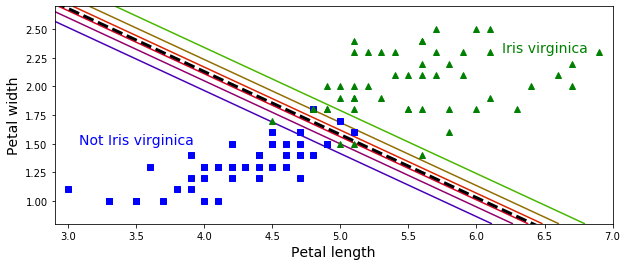

In [31]:
## Get meshgrid 
## @note: reshaping here doesn't seem to be doing anything 
## .. maybe used to 'force' final shape for x0 and x1. 
x0, x1 = np.meshgrid(
    np.linspace(2.9,7,500).reshape(-1,1),
    np.linspace(.8,2.7,200).reshape(-1,1)
)

## Get X_new by concat. x0,x1 (x-y axis for plot) 
X_new = np.c_[x0.ravel(), x1.ravel()] 
yhat_proba = lr.predict_proba(X_new) # to get countours..
yhat = lr.predict(X_new)


## Use X and y (actual dat) for scatter plot 
plt.figure(figsize=(10,4))
plt.plot(X[y==0,0], X[y==0,1], 'bs')
plt.plot(X[y==1,0], X[y==1,1], 'g^') 

## Get countour
## y_proba[:,1] <=> probab. of 'positive' label 
## .. that has a shape = (100000,)
## .. force it to (200,500) to plot
zz = y_proba[:,1].reshape(x0.shape)
plt.contour(x0,x1,zz,cmap=plt.cm.brg) ## brg color scheme for zz (3rd dim)

## Get boundary 
## To get boundary, select 2 points (2.9 and 7)
## question?? why dividing  (b1 * x + b0) by b2 
## Ok it's a formula.. x2 = - ø1/ø2 * x1 - ø0/ø2
left_right = np.array([2.9, 7])
boundary = -(lr.coef_[0][0] * left_right + lr.intercept_[0]) / lr.coef_[0][1]
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.axis([2.9,7,.8,2.7])

plt.clabel(contour, inline=1, fontsize=12)

plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.show()

### Softmax Regression

## 12. Implement Batch GD with early stopping for Softmax regression

Key steps: 
1. Get data, split into train-test splits
2. Transform y-class labels -> one hot vector (Softmax requires target class probabilities)
3. Implement softmax function
4. Train model
5. Add regularization
6. Add early stoppage

In [3]:
import random

In [4]:
## 1. Get data and split intro train-test splits
np.random.seed(2042)
iris = datasets.load_iris()
X = iris.data[:,(2,3)] # petal length and width 
y = iris.target 

## Add bias term to very instance 
X = np.c_[np.ones([len(X),1]), X]
total_size = len(X)
val_ratio = 0.2 
test_ratio = 0.2

## Split into train/validation/test
val_size = int(val_ratio * total_size)
test_size = int(test_ratio*total_size)
train_size = total_size - val_size - test_size
randn_indices = np.random.permutation(len(X))

X_train = X[randn_indices[:train_size]]
X_val = X[randn_indices[train_size:-test_size]] # from train_size+1 to test_size-1
X_test = X[-test_size:]
print("Sum of splits match overll len: {}".format(
   (len(X_train) + len(X_test) + len(X_val))))

y_train = y[randn_indices[:train_size]]
y_val = y[randn_indices[train_size:-test_size]] 
y_test = y[randn_indices[-test_size:]]

Sum of splits match overll len: 150


In [5]:
## 2. One hot y class labels
def one_hot(y):
    m = len(y) 
    n = y.max() + 1 
    one_hot_y = np.zeros((m, n))
    one_hot_y[np.arange(m),y] = 1 # Not sure why one_hot_y[:,y] doesnt work 
    ## Alternatively, one_hot_y[range(0,m),y]=1 is equivalent 
    
    return(one_hot_y)
        
one_hot(y_train)[:5]


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [6]:
Y_train_one_hot = one_hot(y_train)
Y_val_one_hot = one_hot(y_val)
Y_test_one_hot = one_hot(y_test)

In [7]:
## 3. Implement softmax function
def softmax(logits):
    ## First get exponent of score for class k 
    ## Scores are also called logits or log-odds 
    exps = np.exp(logits)
    
    ## Estimate probability p_hat_k 
    ## Prob of instane belonging to class k 
    ## Softmax compute exp. of every score then 
    ## normalizes them (w/ the sum of all exponents )
    sum_exps = np.sum(exps, axis = 1, keepdims=True)
    return exps/sum_exps

In [8]:
## 4. Train model 
n_inputs = X_train.shape[1] ## n features (length+width+bias term)
n_outputs = len(np.unique(y_train)) # 3 classes 

eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs) # Rand from normal dist. 

for i in range(n_iterations):
    # Get logit (score)
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits) 
    loss = - np.mean(np.sum(Y_train_one_hot * np.log(Y_proba+epsilon),axis=1))
    error = Y_proba - Y_train_one_hot
    if i % 500 == 0: 
        print("Iteration: {} Loss:{}".format(i, loss))
    gradient_vect = 1/m * X_train.T.dot(error) ##??
    Theta = Theta - gradient_vect * eta

## Dissect the above step by step

Iteration: 0 Loss:5.446205811872683
Iteration: 500 Loss:0.8350062641405651
Iteration: 1000 Loss:0.6878801447192402
Iteration: 1500 Loss:0.6012379137693314
Iteration: 2000 Loss:0.5444496861981872
Iteration: 2500 Loss:0.5038530181431525
Iteration: 3000 Loss:0.47292289721922487
Iteration: 3500 Loss:0.44824244188957774
Iteration: 4000 Loss:0.4278651093928793
Iteration: 4500 Loss:0.41060071429187134
Iteration: 5000 Loss:0.3956780375390374


In [9]:
logits = X_val.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_val)
accuracy_score

0.9666666666666667

In [17]:
## Add l2 regularization
eta = 0.1 
n_iterations = 5001 
m = len(X_train)
epsilon = 1e-7
alpha = .1 

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    loss = (-np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon),axis=1)) + 
        1/2 * alpha * np.sum(np.square(Theta[1:]))) 
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print("Iteration: {} Loss:{}".format(iteration, loss))
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - gradients * eta 

                  

Iteration: 0 Loss:1.917176734451636
Iteration: 500 Loss:0.5274853292670175
Iteration: 1000 Loss:0.5018023845792812
Iteration: 1500 Loss:0.4940174227384021
Iteration: 2000 Loss:0.4910256015839492
Iteration: 2500 Loss:0.4897840819604775
Iteration: 3000 Loss:0.48924876073664014
Iteration: 3500 Loss:0.48901277816751293
Iteration: 4000 Loss:0.4889073274143668
Iteration: 4500 Loss:0.4888597962589991
Iteration: 5000 Loss:0.48883825099436923


In [18]:
logits = X_val.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_val)
accuracy_score

1.0

In [27]:
# Now let's add early stopping. For this we just need to measure the loss on the validation 
# set at every iteration and stop when the error starts growing.

eta = .1
n_iterations = 5001 
m = len(X_train)
epsilon = 1e-7 
alpha = .1 
loss_val_max = np.inf

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta) ## 90 x 3 matrix, each row has score for each class 
    Y_proba = softmax(logits)
    loss = (-np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon),axis=1)) + 
        1/2 * alpha * np.sum(np.square(Theta[1:]))) 
    error = Y_proba - Y_train_one_hot
    
    if iteration % 500 == 0:
        print("Iteration: {} Loss:{}".format(iteration, loss))
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - gradients * eta 
    
    ## Add early stopping 
    logits_val = X_val.dot(Theta)
    Y_proba_val = softmax(logits_val)
    loss_val = (-np.mean(np.sum(Y_val_one_hot * np.log(Y_proba_val + epsilon),axis=1)) + 
        1/2 * alpha * np.sum(np.square(Theta[1:]))) 
    if loss_val <= loss_val_max: 
        loss_val_max = loss_val 
    else:  ## early stop 
        print("Early stop at iteration {}, latest loss: {} and previous max: {}".format(iteration, loss_val, loss_val_max))
        break 
    
    
    
    


Iteration: 0 Loss:2.499818649082916
Iteration: 500 Loss:0.5302027320105995
Iteration: 1000 Loss:0.5025346211976288
Iteration: 1500 Loss:0.494285402716274
Iteration: 2000 Loss:0.4911340854410904
Iteration: 2500 Loss:0.4898302113666283
Early stop at iteration 2661, latest loss: 0.5325449042485811 and previous max: 0.5325449034479101


In [25]:
logits = X_val.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_val)
accuracy_score

1.0

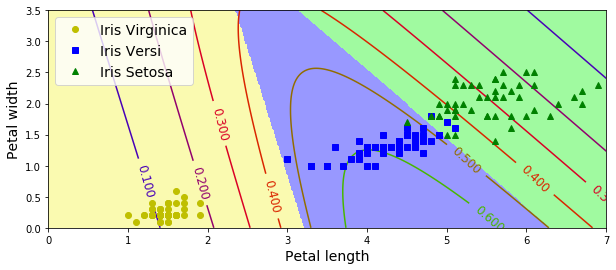

In [85]:
## Plotting predictions: 
x0,x1 = np.meshgrid(
    np.linspace(0, 8, 500).reshape(-1, 1),
    np.linspace(0, 3.5, 200).reshape(-1, 1) ## 500*200=100,000 rows 
)

## Get X_new by concat. x0,x1 (x-y axis for plot) 
X_new = np.c_[x0.ravel(), x1.ravel()]  # 100,000x2
X_new_w_bias = np.c_[np.ones(len(X_new)), X_new] # 100,000x3

logits_plt = X_new_w_bias.dot(Theta)
Y_proba_plt = softmax(logits_plt)
y_predict_plt = np.argmax(Y_proba_plt,axis=1)

zz1 = Y_proba_plt[:,1].reshape(x0.shape)
zz = y_predict_plt.reshape(x0.shape)

plt.figure(figsize=(10,4))
plt.plot(X[y==0,1], X[y==0,2], "yo", label="Iris Virginica")
plt.plot(X[y==1,1], X[y==1,2], "bs", label="Iris Versi")
plt.plot(X[y==2,1], X[y==2,2], "g^", label="Iris Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.contourf(x0,x1,zz,cmap=custom_cmap)
plt.clabel(contour, inline=1, fontsize=12)

plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()